In [1]:
import numpy as np
import cv2
import sys
import os
import pickle
import pandas as pd

from src import RESULT_DIR
from src.utils import conf_mat, MCC, DIS

# Directories
output_dir = os.path.join(RESULT_DIR, 'test_results')
tables_dir = os.path.join(output_dir, 'tables')

In [2]:
def get_table(dbase, video):
    results_csv = os.path.join(tables_dir, 
                               '{0}_full_results.csv'.format(dbase))

    # Columns
    columns = np.concatenate([[k + j for k in ['gt', 'tn', 'fp', 'fn', 'tp']]  
                              for j in ['_fs', '_os', '_ps']])
    all_columns = ['video', 'frame', 'fold'] + list(columns)
    cc = all_columns[4:]
    
    res_df = pd.read_csv(results_csv, index_col=0)
    res_df = res_df[all_columns]
    res_df['MCC'] = res_df.apply(lambda row: MCC(row[cc[0]], row[cc[1]],
                                                row[cc[2]], row[cc[3]]),
                                 axis=1)
    res_df['DIS'] = res_df.apply(lambda row: DIS(row[cc[0]], row[cc[1]],
                                                row[cc[2]], row[cc[3]]),
                                 axis=1)
    res_df = res_df[res_df['video']==video]
    sum_df = res_df.sum()
    # res_df.loc['Average', :] = res_df.mean()
    # res_df.loc['Std. deviation', :] = res_df.std()
    # res_df.loc['Overall', 'MCC'] = MCC(sum_df[cc[0]], sum_df[cc[1]],
    #                                 sum_df[cc[2]], sum_df[cc[3]])
    # res_df.loc['Median', :] = res_df.median()
    # res_df.loc['Overall', 'DIS'] = DIS(sum_df[cc[0]], sum_df[cc[1]],
    #                                 sum_df[cc[2]], sum_df[cc[3]])
    # res_df = res_df[['MCC', 'DIS']]
    # res_df = res_df.groupby(['video']).sum()
    return res_df


dbase = 'LightGBM'
video = 1
vid_fold = 'video'


dbases = ['DAOMC', 'ADMULT', 'MCBS_Both', 'mcDTSR', 'TCF_LMO',
          'LightGBM_temporal','LightGBM_warp']
results = {}
res_tables = {d:get_table(d, video=video) for d in dbases}
methods = list(res_tables.keys())
for t in methods:
    results[t] = {}

    res = res_tables[t]
    results[t]['MCC_frame_frm'] = list(res.apply(lambda row: MCC(row['tn_fs'], row['fp_fs'],
                                                row['fn_fs'], row['tp_fs']),
                                                axis=1).values)
    results[t]['MCC_object_frm'] = list(res.apply(lambda row: MCC(row['tn_os'], row['fp_os'],
                                                row['fn_os'], row['tp_os']),
                                                axis=1).values)
    results[t]['MCC_pixel_frm'] = list(res.apply(lambda row: MCC(row['tn_ps'], row['fp_ps'],
                                                row['fn_ps'], row['tp_ps']),
                                                axis=1).values)
    results[t]['MCC_frame_vid'] = MCC(res['tn_fs'].sum(), res['fp_fs'].sum(), res['fn_fs'].sum(), res['tp_fs'].sum())
    results[t]['MCC_object_vid'] = MCC(res['tn_os'].sum(), res['fp_os'].sum(), res['fn_os'].sum(), res['tp_os'].sum())
    results[t]['MCC_pixel_vid'] = MCC(res['tn_ps'].sum(), res['fp_ps'].sum(), res['fn_ps'].sum(), res['tp_ps'].sum())
results

{'DAOMC': {'MCC_frame_frm': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
  

In [3]:
def frame_eval(vid, gt):
    gth, tn, fp, fn, tp = 0, 0, 0, 0, 0

    if 1 in gt:

        # has bounding box
        gth = 1

        # Checking if there is any detection
        if np.sum(vid) > 0:
            tp = 1
        else:
            fn = 1

    else:

        if np.sum(vid) > 0:
            fp = 1
        else:
            tn = 1

    return gth, tn, fp, fn, tp


def object_eval(vid, gt):

    # vid - predicted frame
    # gt  - ground truth

    gth, tn, fp, fn, tp = 0, 0, 0, 0, 0

    # if ground truth has an object
    if 1 in gt:

        gth = 1

        # regions inside and outside bb
        ins_region = (gt == 1).astype(np.uint8)
        out_region = (gt == 0).astype(np.uint8)

        # Checking blobs inside BB
        if (vid * ins_region).sum() > 0:
            tp = 1
        else:
            fn = 1

        # Counting blobs
        blobs_img = cv2.connectedComponents(vid.astype('uint8'))[1]

        ins_blobs = np.unique(ins_region * blobs_img)
        out_blobs = np.unique(out_region * blobs_img)

        extra_blobs = [k for k in out_blobs if k not in ins_blobs]

        # Has extra blobs
        if len(extra_blobs) > 0:
            fp = 1
        else:
            fp = 0

    # If the frame doesn't have a bounding box:
    else:
        if np.sum(vid) > 0:
            fp = 1
        else:
            tn = 1
    return gth, tn, fp, fn, tp


def pixel_eval(vid, gt):

    # Flattening arrays
    vid_arr = vid.flatten()
    gt_arr = gt.flatten()

    # have bounding box
    gth = int(np.sum(gt_arr) > 0)

    # find valid pixels
    valid_pix = np.where(gt_arr != 2)

    # confusion matrix
    tn, fp, fn, tp = conf_mat(gt_arr[valid_pix], vid_arr[valid_pix]).ravel()
    return gth, tn, fp, fn, tp


In [4]:
vid_paths = ['/home/luiz.tavares/Workspace/VDAO_Pixel/results/test_results/{0}'.format(d) for d in dbases]
sil_path = '/home/luiz.tavares/Workspace/VDAO_Pixel/results/test_results/silhouette/'
box_path = '/home/luiz.tavares/Workspace/VDAO_Pixel/results/test_results/bbox/'

In [5]:
vv = 1
slh = pickle.load(open(os.path.join(sil_path, '{0:02d}.pkl'.format(vv)), 'rb'))
mtd = [pickle.load(open(os.path.join(v, '{0:02d}.pkl'.format(vv)), 'rb')) for v in vid_paths]
bbx = pickle.load(open(os.path.join(box_path, '{0:02d}.pkl'.format(vv)), 'rb'))

In [6]:
ss  = [m['pre_subsampling'] for m in mtd]
vid = [m['video'] for m in mtd]
box = bbx['video']
sil = slh['video']
ss[-1] = 8

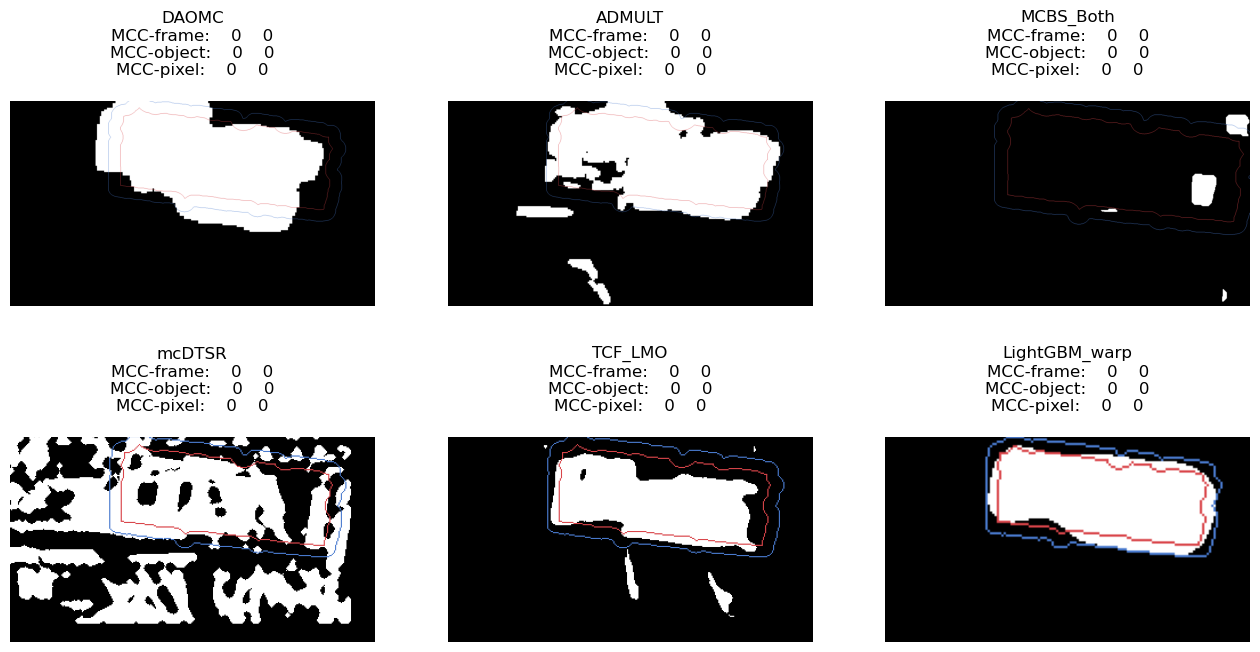

In [9]:
import matplotlib.pyplot as plt

frame = 150

bases = dbases = ['DAOMC', 'ADMULT', 'MCBS_Both', 'mcDTSR', 'TCF_LMO','LightGBM_warp']
vid_frame = [v[frame]*255 for v in vid]
box_frame = [box[frame, ::s, ::s]*255 for s in ss]
sil_frame = [sil[frame, ::s, ::s]*255 for s in ss]

sil_in  = [cv2.findContours((k > 200).astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0] for k in sil_frame]
sil_out = [cv2.findContours((k > 100).astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0] for k in sil_frame]
box_outline = [cv2.findContours((k > 127).astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
               for k in box_frame]


out_frms = [cv2.cvtColor(f.astype('uint8').copy(), cv2.COLOR_GRAY2RGB) for f in vid_frame]
for ff in range(len(out_frms)):
   # cv2.drawContours(out_frms[ff], box_outline[ff], -1, (209, 191, 86, 0.5), 1)
   cv2.drawContours(out_frms[ff], sil_in[ff], -1, (217, 69, 74, 0.5), 1) 
   cv2.drawContours(out_frms[ff], sil_out[ff], -1, (74, 123, 207, 0.5), 1) 
# [cv2.drawContours(ff, sil_in, -1, (217, 69, 74, 0.5), 1) for ff in out_frms]
# [cv2.drawContours(ff, sil_out, -1, (74, 123, 207, 0.5), 1) for ff in out_frms]


fig, axs = plt.subplots(2, 3, figsize=(16,8))

for k,ax in enumerate(axs.flat):
    title = '{0}\n'.format(bases[k])
    title += 'MCC-frame:    {0}    {1}\n'.format(results[bases[k]]['MCC_frame_frm'][frame], results[bases[k]]['MCC_frame_vid'])
    title += 'MCC-object:    {0}    {1}\n'.format(results[bases[k]]['MCC_frame_frm'][frame], results[bases[k]]['MCC_frame_vid'])
    title += 'MCC-pixel:    {0}    {1}\n'.format(results[bases[k]]['MCC_frame_frm'][frame], results[bases[k]]['MCC_frame_vid'])

    ax.imshow(out_frms[k])
    ax.set_title(title)
    ax.axis('off')

0.6719111559729276

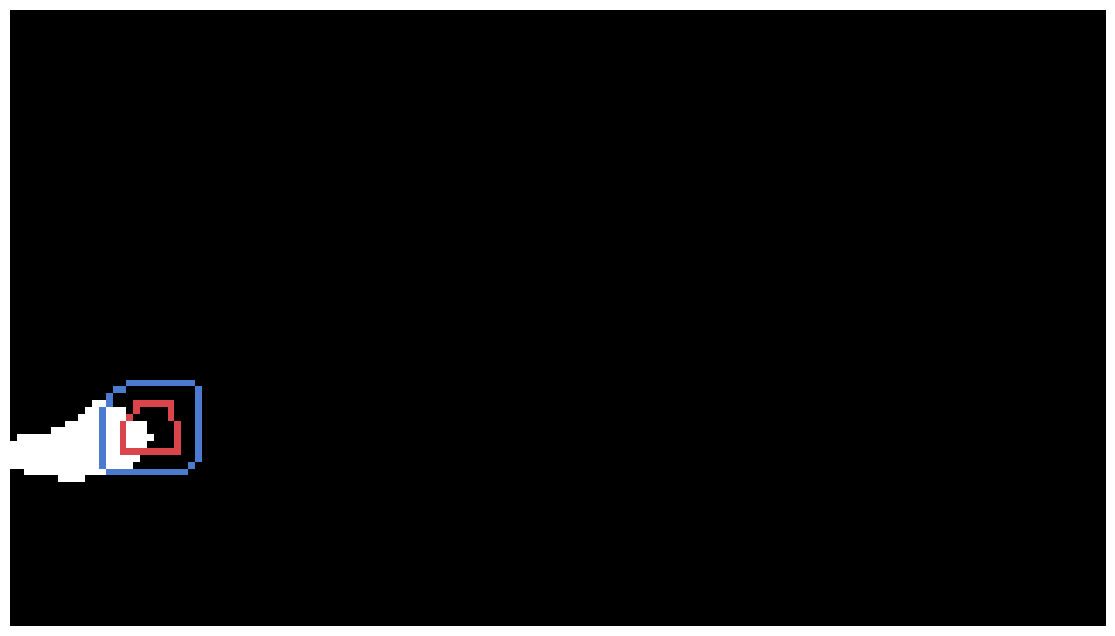

In [77]:
import matplotlib.pyplot as plt

vv = 13
frame = 100

# Certos
# 3, 100 - DIS:    0.0012
# 4, 100 - DIS:    0.0301

# Errados
# 11, 100 - DIS:    0.4458
# 13, 100 - DIS:    0.6719

path='/home/luiz.tavares/Workspace/VDAO_Pixel/data/test/videos/tar/'
cap_tar = cv2.VideoCapture(path + '{0:02d}.avi'.format(vv))
cap_tar.set(cv2.CAP_PROP_POS_FRAMES, frame)

    _, box_frame = cap_box.read()
    _, sil_frame = cap_sil.read()
    _, vid_frame = cap_vid.read()
    _, tar_frame = cap_tar.read()

    # converting target and fix silhouette
    sil_frame[sil_frame>200] = 255
    sil_frame[sil_frame<55]  = 0
    sil_frame[(sil_frame>0) & (sil_frame<255)]  = 127
    box_frame[box_frame>200] = 255
    box_frame[box_frame<55]  = 0
    box_frame[(box_frame>0) & (box_frame<255)]  = 127
    sil_frame = cv2.cvtColor(sil_frame.astype('uint8'), cv2.COLOR_BGR2GRAY)
    box_frame = cv2.cvtColor(box_frame.astype('uint8'), cv2.COLOR_BGR2GRAY)

    # upsampling
    vid_frame = cv2.resize(vid_frame, (tar_frame.shape[1],tar_frame.shape[0]), interpolation=cv2.INTER_NEAREST)
    tar_frame = cv2.cvtColor(tar_frame, cv2.COLOR_BGR2RGB)

slh = pickle.load(open(os.path.join(sil_path, '{0:02d}.pkl'.format(vv)), 'rb'))
mtd = pickle.load(open(os.path.join(vid_paths[-1], '{0:02d}.pkl'.format(vv)), 'rb'))
bbx = pickle.load(open(os.path.join(box_path, '{0:02d}.pkl'.format(vv)), 'rb'))

ss  = mtd['pre_subsampling']
vid = mtd['video']
box = bbx['video']
sil = slh['video']
ss = 8


vid_frame = vid[frame]*255 
box_frame = box[frame, ::ss, ::ss]*255
sil_frame = sil[frame, ::ss, ::ss]*255

sil_in  = cv2.findContours((sil_frame > 200).astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
sil_out = cv2.findContours((sil_frame > 100).astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

vid_frame = cv2.cvtColor(vid_frame, cv2.COLOR_GRAY2RGB)
cv2.drawContours(vid_frame, sil_in, -1, (217, 69, 74, 0.5), 1) 
cv2.drawContours(vid_frame, sil_out, -1, (74, 123, 207, 0.5), 1) 
               
fig = plt.figure(figsize=(16,8))
plt.imshow(vid_frame)
plt.axis('off')

# title = '{0}\n'.format(bases[k])
# title += 'MCC-frame:    {0}    {1}\n'.format(results[bases[k]]['MCC_frame_frm'][frame], results[bases[k]]['MCC_frame_vid'])
# title += 'MCC-object:   {0}    {1}\n'.format(results[bases[k]]['MCC_frame_frm'][frame], results[bases[k]]['MCC_frame_vid'])
# title += 'MCC-pixel:    {0}    {1}\n'.format(results[bases[k]]['MCC_frame_frm'][frame], results[bases[k]]['MCC_frame_vid'])

# #     ax.imshow(out_frms[k])
# #     ax.axis('off')
    
ss = sil[frame, ::ss, ::ss]
ss[ss==0.5]= 2
rr = pixel_eval(vid[frame], ss)
DIS(rr[1],rr[2],rr[3],rr[4])

In [41]:
def pixel_eval(vid, gt):

    # Flattening arrays
    vid_arr = vid.flatten()
    gt_arr = gt.flatten()

    # have bounding box
    gth = int(np.sum(gt_arr) > 0)

    # find valid pixels
    valid_pix = np.where(gt_arr != 2)

    # confusion matrix
    tn, fp, fn, tp = conf_mat(gt_arr[valid_pix], vid_arr[valid_pix]).ravel()
    return gth, tn, fp, fn, tp

MCC-frame:    0    
MCC-object:    0    
MCC-pixel:    0    



In [51]:
np.unique(sil)

array([0. , 0.5, 1. ])